## Load dataset

In [5]:
import os
import ast
import pandas as pd # dataframes
import numpy as np # Mathematical operations
import matplotlib.pyplot as plt # Representation
import random as random
import networkx as nx # Network tools
import spotipy
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from collections import Counter
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from spotipy.oauth2 import SpotifyClientCredentials

# Get workng directory
wd = os.getcwd()

# Read the CSV file and load it into a new DataFrame
spotify_global_data = pd.read_csv(os.path.join(wd, "spotify_global_data.csv"))
print("DataFrame loaded from 'spotify_global_data.csv':")

# Extract node types
country_nodes = list(spotify_global_data.iloc[:, 0])  # Rows represents countries
artist_nodes = list(spotify_global_data.columns[1:])  # Columns represent artists

# Initialize a bipartite graph
B = nx.Graph()

# Add nodes
B.add_nodes_from(country_nodes, bipartite=0)  # Bipartite group 0
B.add_nodes_from(artist_nodes, bipartite=1)  # Bipartite group 1

# Add edges with weights
for index, row in spotify_global_data.iterrows():
    node_a = row.iloc[0]  # First column (country)
    for node_b in artist_nodes:
        weight = row[node_b]
        if pd.notna(weight):  # Add edge if weight is not NaN
            B.add_edge(node_a, node_b, weight=weight)

DataFrame loaded from 'spotify_global_data.csv':


In [16]:
# Defining geographical positions (longitude, latitude) for countries
country_positions = {
    "Catalonia": (1.8677, 41.8205), 
    "Spain": (-3.7492, 40.4637),
    "Argentina": (-63.6167, -38.4161),
    "Brazil": (-51.9253, -14.2350),
    "Italy": (12.5674, 41.8719),
    "France": (1.8883, 46.6034),
    "USA": (-95.7129, 37.0902),
    "Colombia": (-74.2973, 4.5709),
    "UK": (-3.4360, 55.3781),
    "Ecuador": (-78.1834, -1.8312),
    "Mexico": (-102.5528, 23.6345),
    "Chile": (-71.5430, -35.6751),
    "Russia": (105.3188, 61.5240),
    "Germany": (10.4515, 51.1657),
    "Portugal": (-8.2245, 39.3999),
    "South Korea": (127.7669, 35.9078),
    "Venezuela": (-66.5897, 6.4238),
    "Morocco": (-7.0926, 31.7917),
    "Romania": (24.9668, 45.9432),
    "Sweden": (18.6435, 60.1282),
    "India": (78.9629, 20.5937),
    "Uruguay": (-55.7658, -32.5228),
    "Japan": (138.2529, 36.2048),
    "Ireland": (-7.6921, 53.1424),
    "Dominican Republic": (-70.1627, 18.7357),
    "Philippines": (121.7740, 12.8797),
    "Indonesia": (113.9213, -0.7893),
    "Austria": (14.5501, 47.5162),
    "Peru": (-75.0152, -9.1900),
    "Australia": (133.7751, -25.2744),
}
# Helper function to separate overlapping nodes
def repel_nodes(positions, min_dist=0.1):
    for node1, pos1 in positions.items():
        for node2, pos2 in positions.items():
            if node1 != node2:
                dist = np.linalg.norm(np.array(pos1) - np.array(pos2))
                if dist < min_dist:  # If nodes are too close
                    direction = np.array(pos1) - np.array(pos2)
                    direction = direction / np.linalg.norm(direction) if np.linalg.norm(direction) != 0 else np.random.rand(2)
                    positions[node1] += direction * (min_dist - dist) * 0.5
                    positions[node2] -= direction * (min_dist - dist) * 0.5
    return positions

# Generate force-directed layout for artist nodes
country_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 0]
country_labels = {node: node for node in country_nodes}
artist_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == 1]
artist_labels = {node: node for node in artist_nodes}

# Compute positions
fixed_positions = {node: pos for node, pos in country_positions.items() if node in country_nodes}
# Spring layout for artist nodes
positions = nx.spring_layout(B, pos=fixed_positions, fixed=country_nodes, weight="weight", iterations=50,k=5) 

# Apply repulsion to avoid overlapping nodes
artist_positions = {node: positions[node] for node in artist_nodes}
artist_positions = repel_nodes(artist_positions, min_dist=10)

# Combine back the positions, keeping country nodes fixed
for node in country_nodes:
    positions[node] = fixed_positions[node]
for node in artist_nodes:
    positions[node] = artist_positions[node]

# Separate positions for country and artist nodes
country_positions = {node: positions[node] for node in country_nodes}
artist_positions = {node: positions[node] for node in artist_nodes}

# Plotting
plt.figure(figsize=(14, 12))
edge_widths = [((data.get("weight", 1) - 1)/531)*(10)+1 for _, _, data in B.edges(data=True)]


<Figure size 1400x1200 with 0 Axes>

## Q3: Global Superstars Dominate Across Countries: 
We aim to identify the artists who dominate the top artist rankings across the majority of countries. Artists with the highest degree centrality in a bipartite network are those connected to the most countries, making them global superstars. To begin, we will analyze the degree centrality distribution of the artists:

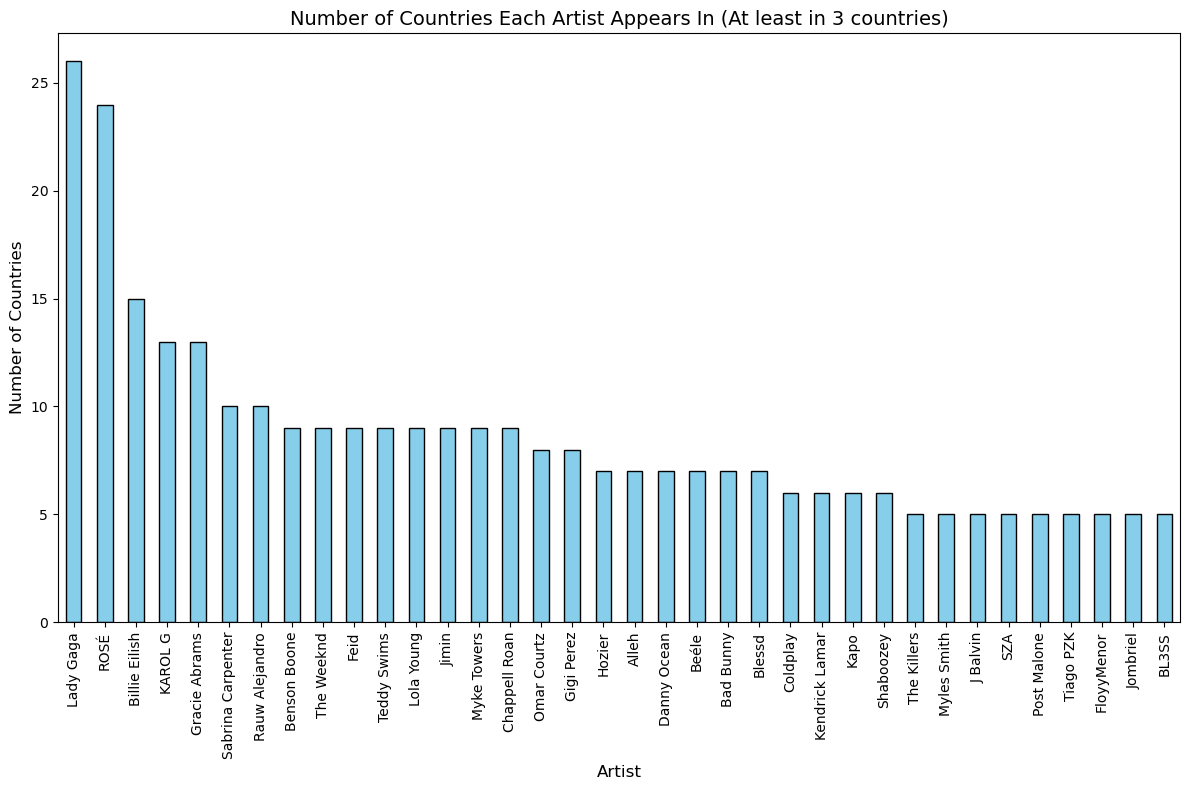

In [115]:
# Count how many countries each artist appears in
artist_country_counts = spotify_global_data.iloc[:, 1:].apply(lambda x: (x > 0).sum(), axis=0)

# Filter out artists who appear less than 5 countries
filtered_artist_counts = artist_country_counts[artist_country_counts > 4]

# Sort artists by the number of countries they appear in (descending order)
sorted_artist_counts = filtered_artist_counts.sort_values(ascending=False)

# Create a bar plot for the number of countries each artist appears in
plt.figure(figsize=(12, 8))
sorted_artist_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Countries Each Artist Appears In (At least in 3 countries)', fontsize=14)
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(rotation=90)  

plt.tight_layout()
plt.show()


In this analysis, we define global superstars as artists who exhibit both widespread influence and high popularity. We use two criteria to identify them: 
1. Cumulative popularity, which reflects the total success of an artist across all countries, ensuring that only highly popular artists are considered. 
2. We look at how often an artist appears in the top 10 rankings across multiple countries. An artist who frequently appears in the top 10 of many countries demonstrates consistent global appeal. 

Combining these two factors allows us to distinguish artists who are not only popular but also maintain a strong and consistent presence across the globe, making them true global superstars.

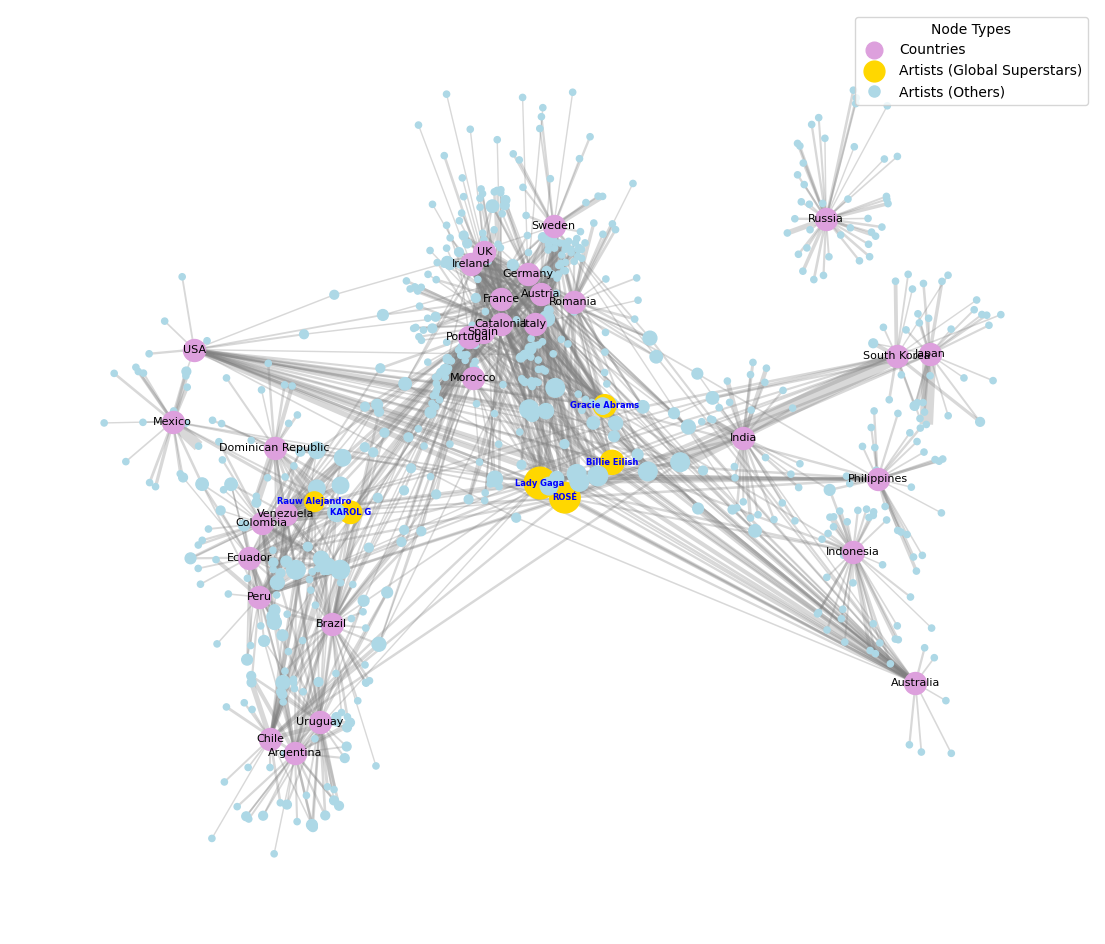

In [ ]:

import matplotlib.lines as mlines

# We first calculate cumulative popularity scores
artist_popularity = spotify_global_data.iloc[:, 1:].sum(axis=0)  # Sum popularity across countries
artist_popularity = artist_popularity.sort_values(ascending=False)

# Find artists in the top 10 for each country
top_10_artists_by_country = spotify_global_data.iloc[:, 1:].apply(
    lambda row: row.nlargest(10).index.tolist(), axis=1
)
top_10_flat = [artist for sublist in top_10_artists_by_country for artist in sublist]

# Count the number of times each artist appears in the top 10
artist_top_10_counts = pd.Series(top_10_flat).value_counts()

# We define "global superstars" as artists with high popularity and frequent top-10 appearances
superstar_threshold = artist_popularity.mean()  # Use mean popularity as a threshold
top_10_threshold = len(spotify_global_data) * 0.2  # Appear in top 10 for at least 20% of countries

global_superstars = artist_top_10_counts[
    (artist_popularity.loc[artist_top_10_counts.index] > superstar_threshold) &
    (artist_top_10_counts > top_10_threshold)
].index

# We will highlight global superstars in the graph with a golden colour and bigger size

artist_node_sizes = [
    20 * B.degree(artist) for artist in artist_nodes  # Scale size by degree
]
artist_node_colors = [
    "gold" if artist in global_superstars else "lightblue" for artist in artist_nodes
]

plt.figure(figsize=(14, 12))

# Draw artist nodes with updated sizes and colors
nx.draw_networkx_nodes(
    B, positions, nodelist=artist_nodes,
    node_size=artist_node_sizes, node_color=artist_node_colors, label="Artists"
)

# Draw country nodes 
nx.draw_networkx_nodes(
    B, positions, nodelist=country_nodes,
    node_size=250, node_color="plum", label="Countries"
)

nx.draw_networkx_edges(B, positions, edge_color="gray", alpha=0.3, width=edge_widths)


nx.draw_networkx_labels(B, country_positions, labels=country_labels, font_size=8, font_color="black")

# Add labels only for global superstars
superstar_labels = {artist: artist for artist in artist_nodes if artist in global_superstars}
nx.draw_networkx_labels(
    B, positions, labels=superstar_labels, font_size=6, font_color="blue", font_weight="bold"
)

# Create legend elements
country_legend = mlines.Line2D([],[],color="plum", marker='o', markersize=12, linestyle='None', label="Countries")
superstar_legend = mlines.Line2D([], [], color="gold", marker='o', linestyle='None',
                                 markersize=15, label="Artists (Global Superstars)")
artist_legend = mlines.Line2D([], [], color="lightblue", marker='o', linestyle='None',
                              markersize=8, label="Artists (Others)")

# Add to the legend
plt.legend(handles=[country_legend, superstar_legend, artist_legend],
           loc="upper right", fontsize=10, title="Node Types")

plt.gca().set_frame_on(False)
plt.show()


## Q4- Regional Preferences

We aim to analyze which countries most actively support their local and regional artists. Since we lack direct information about the nationality of artists, we will categorize them based on their geographic presence. Specifically:

- Local artists are defined as those who appear in exactly one country (degree = 1), indicating they are primarily active in a single country.
- Regional artists are those who appear in 2 to 5 countries, suggesting a broader regional influence.
- Global artists are those who appear in more than 5 countries, representing a worldwide presence.

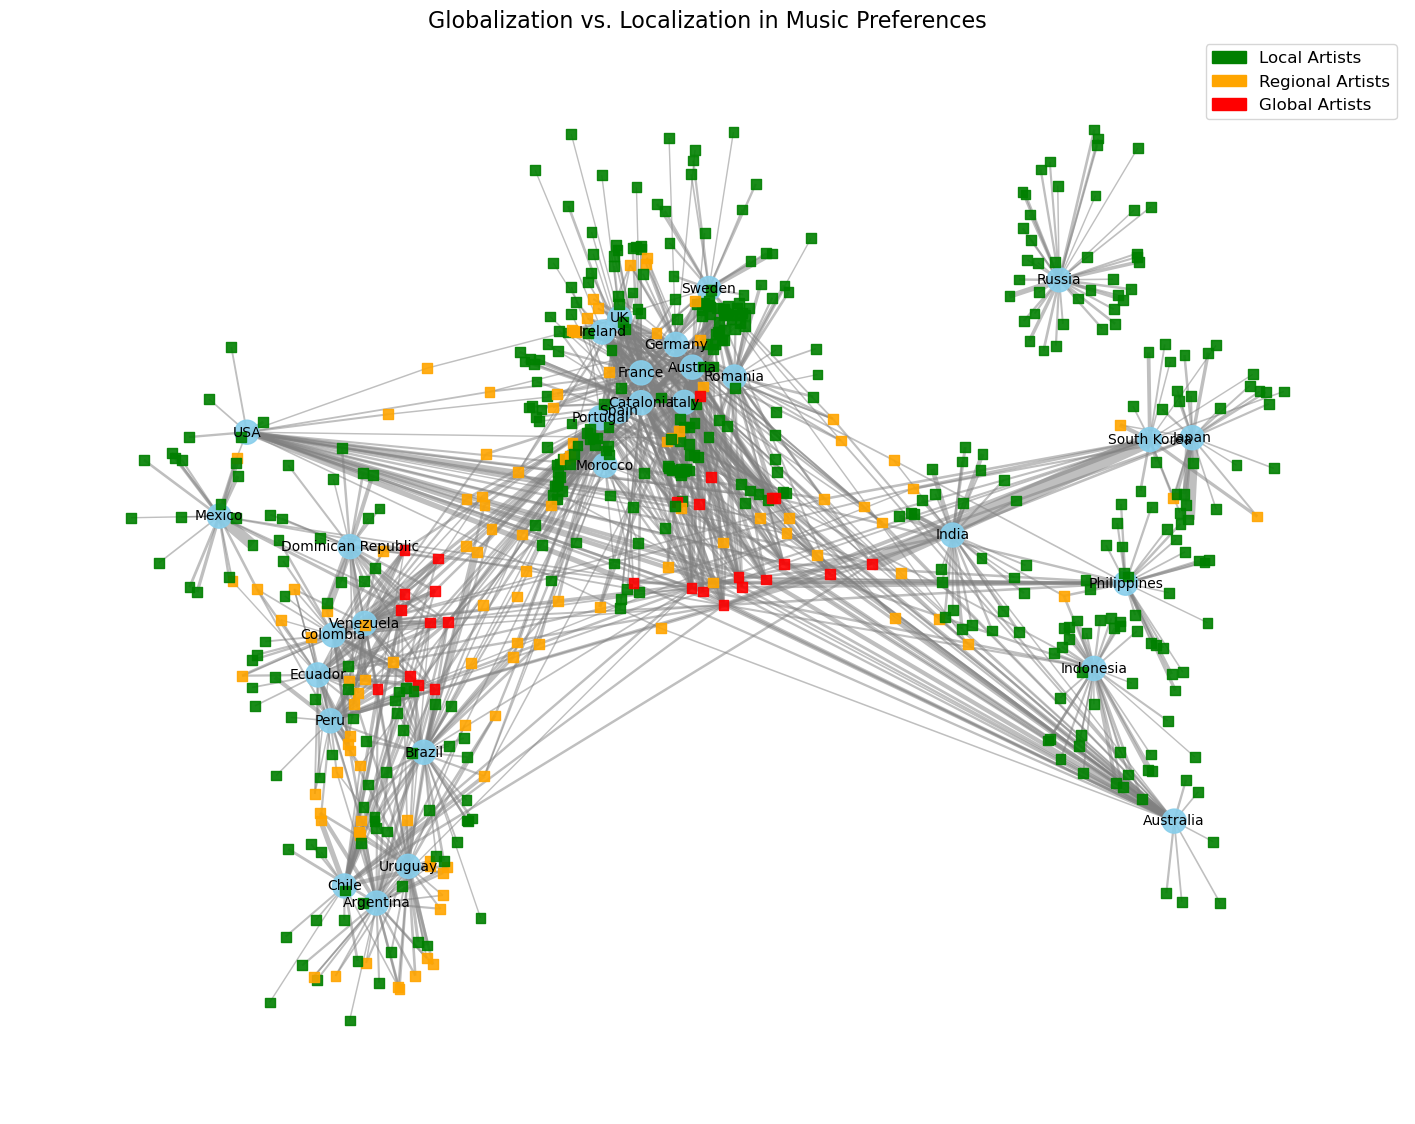

In [111]:
import matplotlib.patches as mpatches

# Extract artist names (columns except the first one)
artist_nodes = spotify_global_data.columns[1:]

# Calculate the number of countries each artist appears in
artist_country_counts = spotify_global_data[artist_nodes].notna().sum(axis=0)

# Define thresholds for local, regional, and global artists
local_threshold = 1  # Appears in exactly 1 country
regional_lower_bound = 2  # Appears in 2 countries
regional_upper_bound = 5  # Appears in up to 5 countries

global_threshold = 5  # Appears in >5 countries 

# Categorize artists based on the thresholds
artist_categories = {}
for artist, count in artist_country_counts.items():
    if count == local_threshold:
        artist_categories[artist] = "Local"
    elif regional_lower_bound <= count <= regional_upper_bound:
        artist_categories[artist] = "Regional"
    elif count > global_threshold:
        artist_categories[artist] = "Global"
    else:
        artist_categories[artist] = "Other"

artist_category_df = pd.DataFrame.from_dict(artist_categories, orient='index', columns=['Category'])

# Count the number of artists in each category
category_counts = artist_category_df['Category'].value_counts()

# Map artist categories to colors
artist_color_map = {
    "Local": "green",
    "Regional": "orange",
    "Global": "red"
}

# Assign node colors and shapes based on classification
node_colors = []
node_shapes = []
node_sizes = []

for node, data in B.nodes(data=True):
    if data.get("bipartite") == 0:  # Country nodes
        node_colors.append("skyblue")
        node_shapes.append("o")  # Circular shape for countries
        node_sizes.append(300)
    else:  # Artist nodes
        artist_category = artist_categories.get(node, "Other")
        node_colors.append(artist_color_map.get(artist_category))  
        node_shapes.append("s")  # Square shape for artists
        node_sizes.append(50)


plt.figure(figsize=(18, 14))

# Draw edges
nx.draw_networkx_edges(
    B,
    pos=positions,
    edgelist=B.edges(data=True),
    width=edge_widths,
    alpha=0.5,
    edge_color="gray",
)

# Separate node drawing for different shapes
for shape, bipartite_group in [("o", 0), ("s", 1)]:
    shape_nodes = [node for node, data in B.nodes(data=True) if data.get("bipartite") == bipartite_group]
    shape_positions = {node: positions[node] for node in shape_nodes}
    shape_colors = [node_colors[i] for i, node in enumerate(B.nodes()) if node in shape_nodes]
    shape_sizes = [node_sizes[i] for i, node in enumerate(B.nodes()) if node in shape_nodes]

    nx.draw_networkx_nodes(
        B,
        pos=shape_positions,
        nodelist=shape_nodes,
        node_color=shape_colors,
        node_size=shape_sizes,
        node_shape=shape,
        alpha=0.9,
    )

# Add labels for countries
nx.draw_networkx_labels(B, pos=country_positions, labels=country_labels, font_size=10, font_color="black")

# Create legend entries for the node colors and shapes
local_patch = mpatches.Patch(color='green', label='Local Artists')
regional_patch = mpatches.Patch(color='orange', label='Regional Artists')
global_patch = mpatches.Patch(color='red', label='Global Artists')

# Add the legend to the plot
plt.legend(handles=[local_patch, regional_patch, global_patch], loc='upper right', fontsize=12)

plt.title("Globalization vs. Localization in Music Preferences", fontsize=16)
plt.axis("off")
plt.show()


<Figure size 1400x800 with 0 Axes>

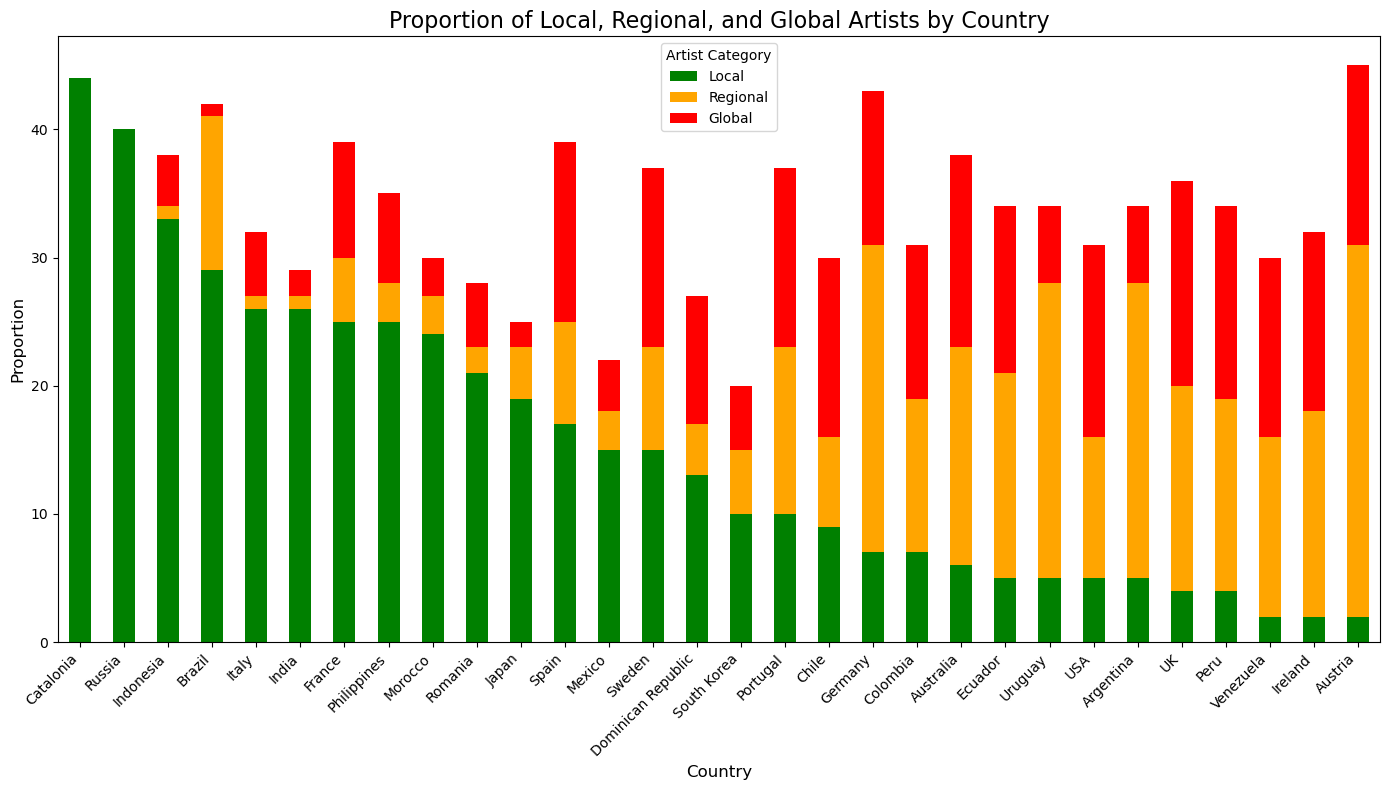

In [108]:
# Prepare data for the stacked bar chart
country_artist_categories = {
    country: {"Local": 0, "Regional": 0, "Global": 0}
    for country in spotify_global_data.iloc[:, 0]
}

# Populate counts based on artist categories
for country in spotify_global_data.iloc[:, 0]:
    country_artists = spotify_global_data.loc[spotify_global_data.iloc[:, 0] == country, artist_nodes]
    country_artist_counts = country_artists.notna().sum(axis=0)
    country_included_artists = country_artist_counts[country_artist_counts > 0]
    for artist, count in country_included_artists.items():
        category = artist_categories.get(artist, "Other")
        if category in country_artist_categories[country]:
            country_artist_categories[country][category] += 1

# Convert counts to a DataFrame
country_artist_df = pd.DataFrame(country_artist_categories).T

# Sort the country_artist_df by the 'Local' column in descending order
country_artist_df_sorted = country_artist_df.sort_values(by="Local", ascending=False)

# Plot the stacked bar chart with the sorted data
plt.figure(figsize=(14, 8))

# Define colors for each category
colors = {"Local": "green", "Regional": "orange", "Global": "red"}

country_artist_df_sorted.plot(
    kind="bar",
    stacked=True,
    color=[colors["Local"], colors["Regional"], colors["Global"]],
    figsize=(14, 8),
)

# Add chart details
plt.title("Proportion of Local, Regional, and Global Artists by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Artist Category", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

plt.show()

